In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from transformers import BertTokenizerFast, TFBertForSequenceClassification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from transformers import DataCollatorWithPadding
from transformers import create_optimizer
from datasets import Dataset
import tensorflow as tf

nltk.download('punkt')
nltk.download('stopwords')

2025-05-23 23:49:49.494941: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748044189.706665      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748044189.770981      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
data_train = 'https://raw.githubusercontent.com/Frazanhibriz/EmotionAnalysis-NLP/refs/heads/main/dataset/train.txt'
data_test = 'https://raw.githubusercontent.com/Frazanhibriz/EmotionAnalysis-NLP/refs/heads/main/dataset/test.txt'
data_val = 'https://raw.githubusercontent.com/Frazanhibriz/EmotionAnalysis-NLP/refs/heads/main/dataset/val.txt'

try:
  df_train = pd.read_csv(data_train, delimiter=';', header=None, names=['Sentence', 'Label'])
  print("Dataset train loaded successfully:")
  print(df_train.head())
except Exception as e:
  print(f"Error loading dataset: {e}")

try:
  df_test = pd.read_csv(data_test, delimiter=';', header=None, names=['Sentence', 'Label'])
  print("Dataset test loaded successfully:")
  print(df_test.head())
except Exception as e:
  print(f"Error loading dataset: {e}")

try:
  df_val = pd.read_csv(data_val, delimiter=';', header=None, names=['Sentence', 'Label'])
  print("Dataset val loaded successfully:")
  print(df_val.head())
except Exception as e:
  print(f"Error loading dataset: {e}")


Dataset train loaded successfully:
                                            Sentence    Label
0                            i didnt feel humiliated  sadness
1  i can go from feeling so hopeless to so damned...  sadness
2   im grabbing a minute to post i feel greedy wrong    anger
3  i am ever feeling nostalgic about the fireplac...     love
4                               i am feeling grouchy    anger
Dataset test loaded successfully:
                                            Sentence    Label
0  im feeling rather rotten so im not very ambiti...  sadness
1          im updating my blog because i feel shitty  sadness
2  i never make her separate from me because i do...  sadness
3  i left with my bouquet of red and yellow tulip...      joy
4    i was feeling a little vain when i did this one  sadness
Dataset val loaded successfully:
                                            Sentence    Label
0  im feeling quite sad and sorry for myself but ...  sadness
1  i feel like i am still look

In [3]:
df_train.head(10)

,Sentence,Label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
5,ive been feeling a little burdened lately wasn...,sadness
6,ive been taking or milligrams or times recomme...,surprise
7,i feel as confused about life as a teenager or...,fear
8,i have been with petronas for years i feel tha...,joy
9,i feel romantic too,love


In [4]:
df_test.head(10)

,Sentence,Label
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,joy
4,i was feeling a little vain when i did this one,sadness
5,i cant walk into a shop anywhere where i do no...,fear
6,i felt anger when at the end of a telephone call,anger
7,i explain why i clung to a relationship with a...,joy
8,i like to have the same breathless feeling as ...,joy
9,i jest i feel grumpy tired and pre menstrual w...,anger


In [5]:
df_val.head(10)

,Sentence,Label
0,im feeling quite sad and sorry for myself but ...,sadness
1,i feel like i am still looking at a blank canv...,sadness
2,i feel like a faithful servant,love
3,i am just feeling cranky and blue,anger
4,i can have for a treat or if i am feeling festive,joy
5,i start to feel more appreciative of what god ...,joy
6,i am feeling more confident that we will be ab...,joy
7,i feel incredibly lucky just to be able to tal...,joy
8,i feel less keen about the army every day,joy
9,i feel dirty and ashamed for saying that,sadness


# EDA

## Data Training

In [6]:
print(df_train.isnull().sum())
print(30 * "=")
print(df_test.isnull().sum())
print(30 * "=")
print(df_val.isnull().sum())

Sentence    0
Label       0
dtype: int64
Sentence    0
Label       0
dtype: int64
Sentence    0
Label       0
dtype: int64


In [7]:
df_train['Label'].value_counts()

Label
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64

In [8]:
print(df_train.info())
print("=" * 70)
print(df_train.describe(include='object'))
print("=" * 70)
print(df_train.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  16000 non-null  object
 1   Label     16000 non-null  object
dtypes: object(2)
memory usage: 250.1+ KB
None
                                                 Sentence  Label
count                                               16000  16000
unique                                              15969      6
top     im still not sure why reilly feels the need to...    joy
freq                                                    2   5362
(16000, 2)


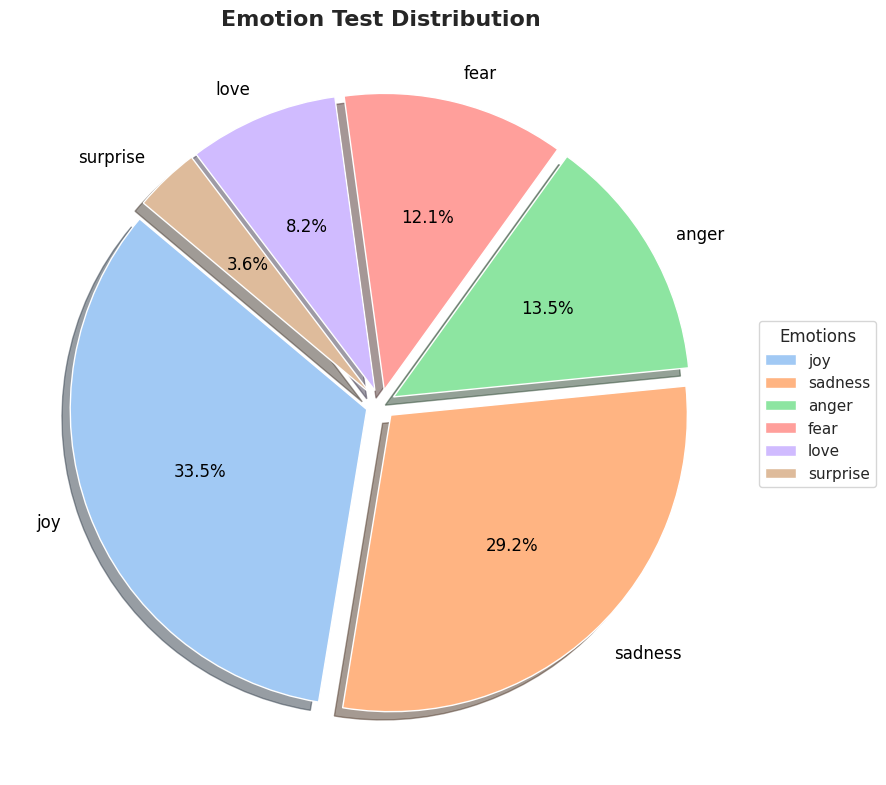

In [9]:
label_counts = df_train['Label'].value_counts()

colors = sns.color_palette("pastel", n_colors=len(label_counts))

sns.set(style="white")

fig, ax = plt.subplots(figsize=(9, 9))

explode = [0.05] * len(label_counts)
wedges, texts, autotexts = ax.pie(
    label_counts,
    labels=label_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    explode=explode,
    shadow=True,
    textprops={'fontsize': 12, 'color': 'black'}
)

ax.legend(wedges, label_counts.index, title="Emotions", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.title("Emotion Test Distribution", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [10]:
df_train = df_train.drop(df_train[df_train['Label'] == 'love'].index )
df_train = df_train.drop(df_train[df_train['Label'] == 'surprise'].index )

In [11]:
df_train.Label.value_counts()

Label
joy        5362
sadness    4666
anger      2159
fear       1937
Name: count, dtype: int64

In [12]:
joy = df_train[df_train['Label'] == 'joy'].sample(n = 2200 ,random_state = 42)
sadness = df_train[df_train['Label'] == 'sadness'].sample(n = 2200 ,random_state = 42)
anger = df_train[df_train['Label'] == 'anger'].sample(n = 2159 ,random_state = 42)
fear = df_train[df_train['Label'] == 'fear'].sample(n = 1937 ,random_state = 42)
df_sampled  = pd.concat([joy , sadness , anger , fear])

df_train = df_sampled.sample(frac=1, random_state=20).reset_index(drop=True)

In [13]:
df_train.Label.value_counts()

Label
joy        2200
sadness    2200
anger      2159
fear       1937
Name: count, dtype: int64

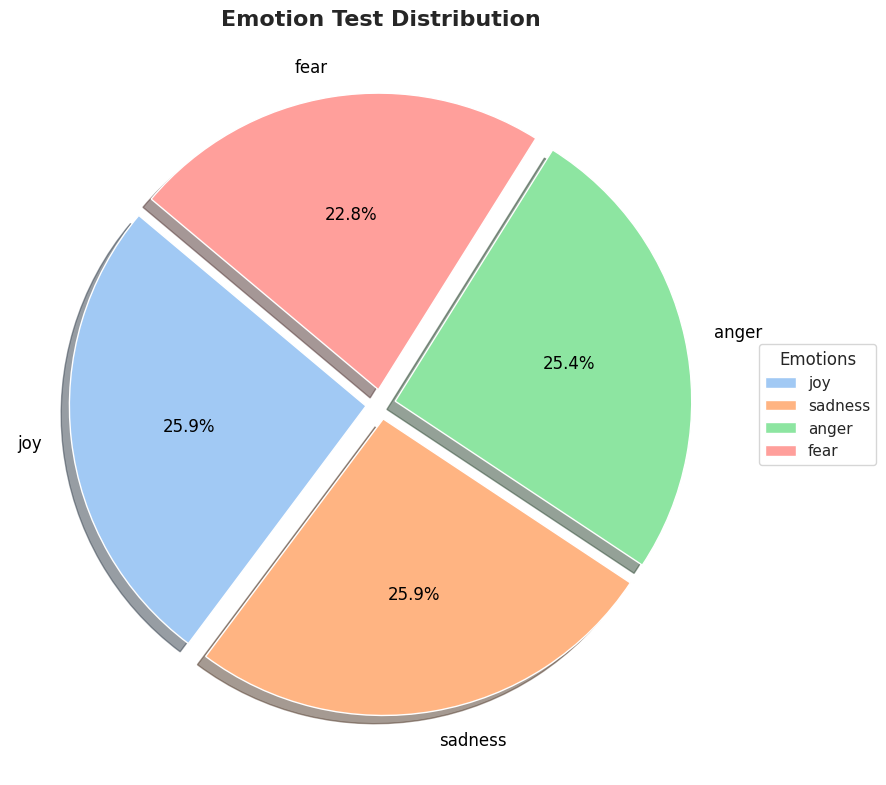

In [14]:
label_counts = df_train['Label'].value_counts()

colors = sns.color_palette("pastel", n_colors=len(label_counts))

sns.set(style="white")

fig, ax = plt.subplots(figsize=(9, 9))

explode = [0.05] * len(label_counts)
wedges, texts, autotexts = ax.pie(
    label_counts,
    labels=label_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    explode=explode,
    shadow=True,
    textprops={'fontsize': 12, 'color': 'black'}
)

ax.legend(wedges, label_counts.index, title="Emotions", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.title("Emotion Test Distribution", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## Data Test

In [15]:
df_test['Label'].value_counts()

Label
joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: count, dtype: int64

In [16]:
print(df_test.info())
print("=" * 70)
print(df_test.describe(include='object'))
print("=" * 70)
print(df_test.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  2000 non-null   object
 1   Label     2000 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB
None
                                                 Sentence Label
count                                                2000  2000
unique                                               2000     6
top     i feel all weird when i have to meet w people ...   joy
freq                                                    1   695
(2000, 2)


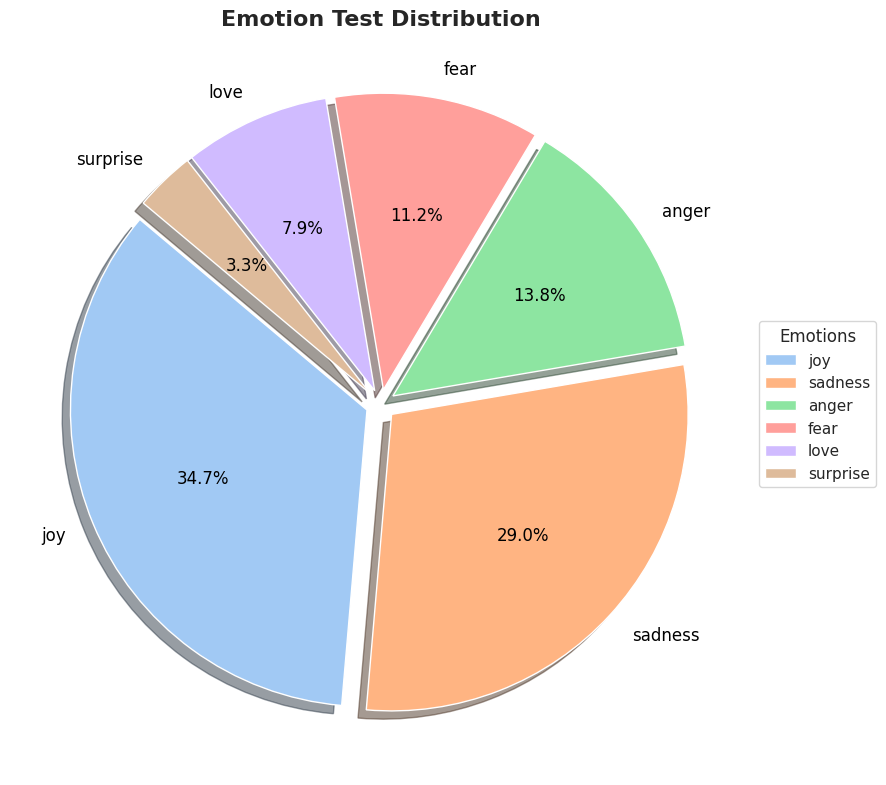

In [17]:
label_counts = df_test['Label'].value_counts()

colors = sns.color_palette("pastel", n_colors=len(label_counts))

sns.set(style="white")

fig, ax = plt.subplots(figsize=(9, 9))

explode = [0.05] * len(label_counts)
wedges, texts, autotexts = ax.pie(
    label_counts,
    labels=label_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    explode=explode,
    shadow=True,
    textprops={'fontsize': 12, 'color': 'black'}
)

ax.legend(wedges, label_counts.index, title="Emotions", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.title("Emotion Test Distribution", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [18]:
df_test = df_test.drop(df_test[df_test['Label'] == 'love'].index )
df_test = df_test.drop(df_test[df_test['Label'] == 'surprise'].index )

In [19]:
df_test.Label.value_counts()

Label
joy        695
sadness    581
anger      275
fear       224
Name: count, dtype: int64

In [20]:
joy = df_test[df_test['Label'] == 'joy'].sample(n = 250 ,random_state = 42)
sadness = df_test[df_test['Label'] == 'sadness'].sample(n = 250 ,random_state = 42)
anger = df_test[df_test['Label'] == 'anger'].sample(n = 215 ,random_state = 42)
fear = df_test[df_test['Label'] == 'fear'].sample(n = 224 ,random_state = 42)
df_sampled  = pd.concat([joy , sadness , anger , fear])

df_test = df_sampled.sample(frac=1, random_state=20).reset_index(drop=True)

In [21]:
df_test.Label.value_counts()

Label
joy        250
sadness    250
fear       224
anger      215
Name: count, dtype: int64

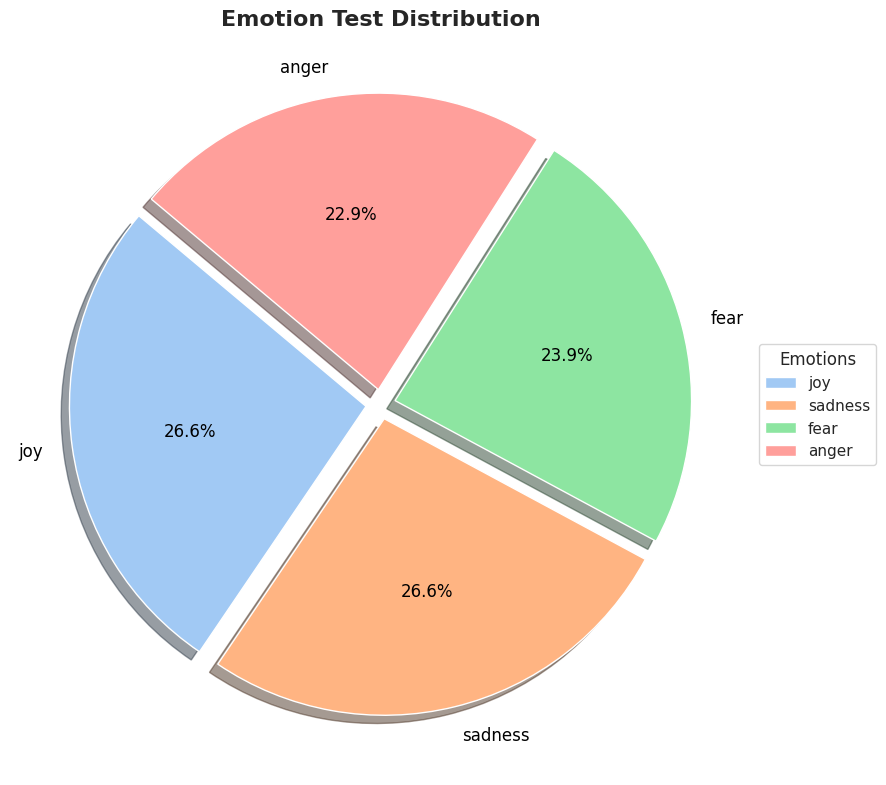

In [22]:
label_counts = df_test['Label'].value_counts()

colors = sns.color_palette("pastel", n_colors=len(label_counts))

sns.set(style="white")

fig, ax = plt.subplots(figsize=(9, 9))

explode = [0.05] * len(label_counts)
wedges, texts, autotexts = ax.pie(
    label_counts,
    labels=label_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    explode=explode,
    shadow=True,
    textprops={'fontsize': 12, 'color': 'black'}
)

ax.legend(wedges, label_counts.index, title="Emotions", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.title("Emotion Test Distribution", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## Data Val

In [23]:
df_val['Label'].value_counts()

Label
joy         704
sadness     550
anger       275
fear        212
love        178
surprise     81
Name: count, dtype: int64

In [24]:
print(df_val.info())
print("=" * 70)
print(df_val.describe(include='object'))
print("=" * 70)
print(df_val.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  2000 non-null   object
 1   Label     2000 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB
None
                        Sentence Label
count                       2000  2000
unique                      1998     6
top     i feel so tortured by it   joy
freq                           2   704
(2000, 2)


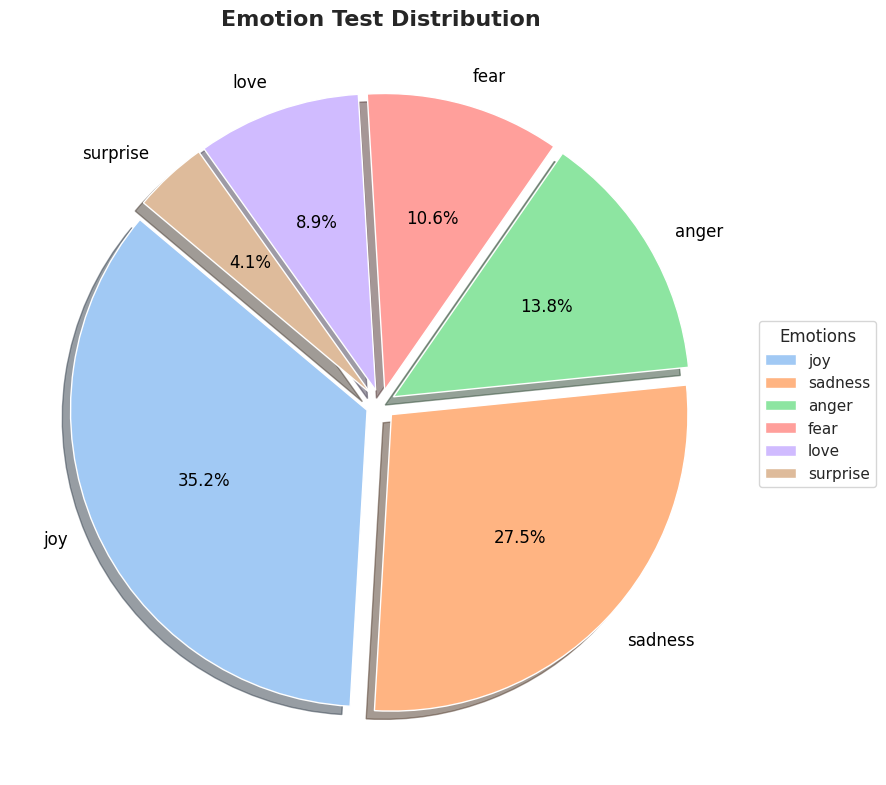

In [25]:
label_counts = df_val['Label'].value_counts()

colors = sns.color_palette("pastel", n_colors=len(label_counts))

sns.set(style="white")

fig, ax = plt.subplots(figsize=(9, 9))

explode = [0.05] * len(label_counts)
wedges, texts, autotexts = ax.pie(
    label_counts,
    labels=label_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    explode=explode,
    shadow=True,
    textprops={'fontsize': 12, 'color': 'black'}
)

ax.legend(wedges, label_counts.index, title="Emotions", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.title("Emotion Test Distribution", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [26]:
df_val = df_val.drop(df_val[df_val['Label'] == 'love'].index )
df_val = df_val.drop(df_val[df_val['Label'] == 'surprise'].index )

In [27]:
df_val.Label.value_counts()

Label
joy        704
sadness    550
anger      275
fear       212
Name: count, dtype: int64

In [28]:
joy = df_val[df_val['Label'] == 'joy'].sample(n = 250 ,random_state = 42)
sadness = df_val[df_val['Label'] == 'sadness'].sample(n = 240 ,random_state = 42)
anger = df_val[df_val['Label'] == 'anger'].sample(n = 275 ,random_state = 42)
fear = df_val[df_val['Label'] == 'fear'].sample(n = 200 ,random_state = 42)
df_sampled  = pd.concat([joy , sadness , anger , fear])

df_val = df_sampled.sample(frac=1, random_state=20).reset_index(drop=True)

In [29]:
df_val.Label.value_counts()

Label
anger      275
joy        250
sadness    240
fear       200
Name: count, dtype: int64

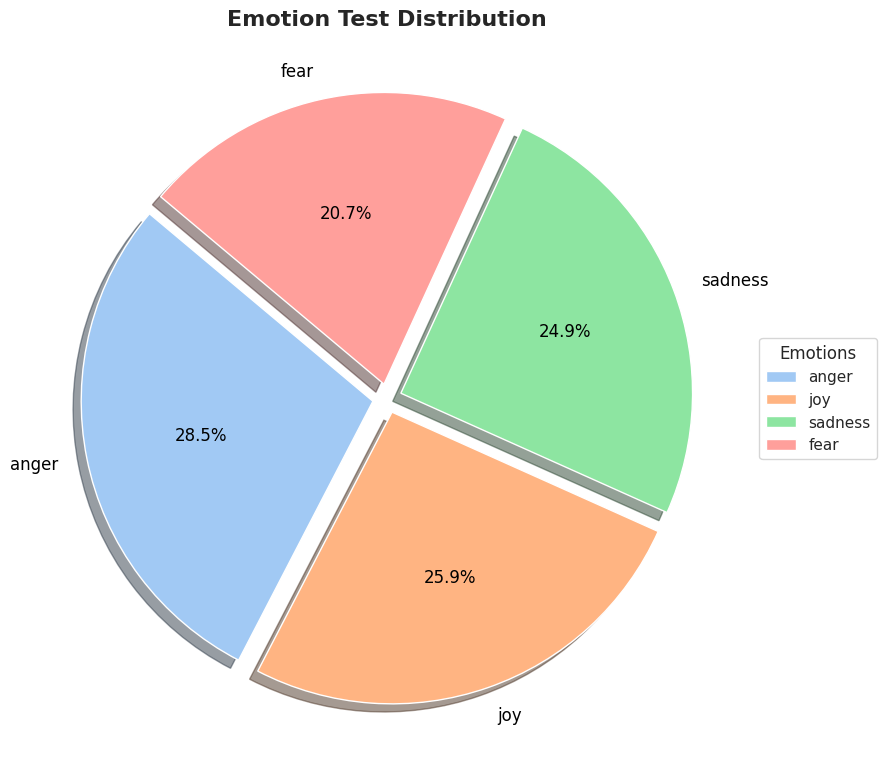

In [30]:
label_counts = df_val['Label'].value_counts()

colors = sns.color_palette("pastel", n_colors=len(label_counts))

sns.set(style="white")

fig, ax = plt.subplots(figsize=(9, 9))

explode = [0.05] * len(label_counts)
wedges, texts, autotexts = ax.pie(
    label_counts,
    labels=label_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    explode=explode,
    shadow=True,
    textprops={'fontsize': 12, 'color': 'black'}
)

ax.legend(wedges, label_counts.index, title="Emotions", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.title("Emotion Test Distribution", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [31]:
def clean_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

df_train['clean_text'] = df_train['Sentence'].apply(clean_text)

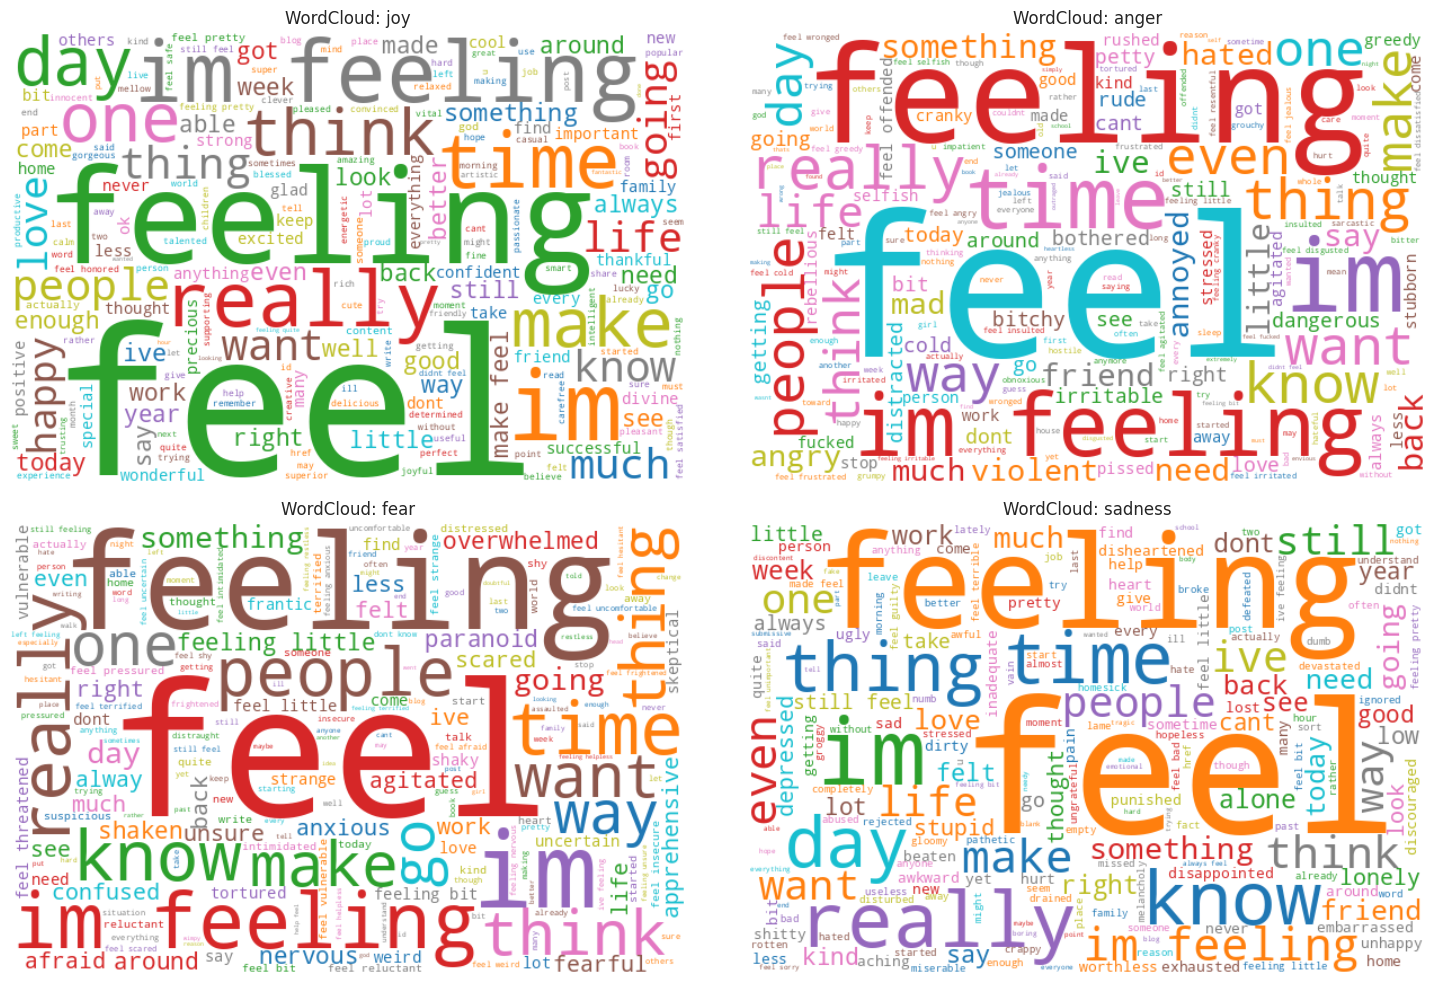

In [32]:
stop_words = set(stopwords.words('english'))

def get_words_by_label(label):
    texts = df_train[df_train['Label'] == label]['clean_text']
    words = []
    for text in texts:
        words.extend([word for word in word_tokenize(text) if word not in stop_words])
    return words

labels = df_train['Label'].unique()
plt.figure(figsize=(15, 10))
for i, label in enumerate(labels):
    plt.subplot(2, (len(labels)+1)//2, i+1)
    words = get_words_by_label(label)
    wc = WordCloud(width=600, height=400, background_color='white', colormap='tab10').generate(" ".join(words))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f"WordCloud: {label}")
    plt.axis('off')
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


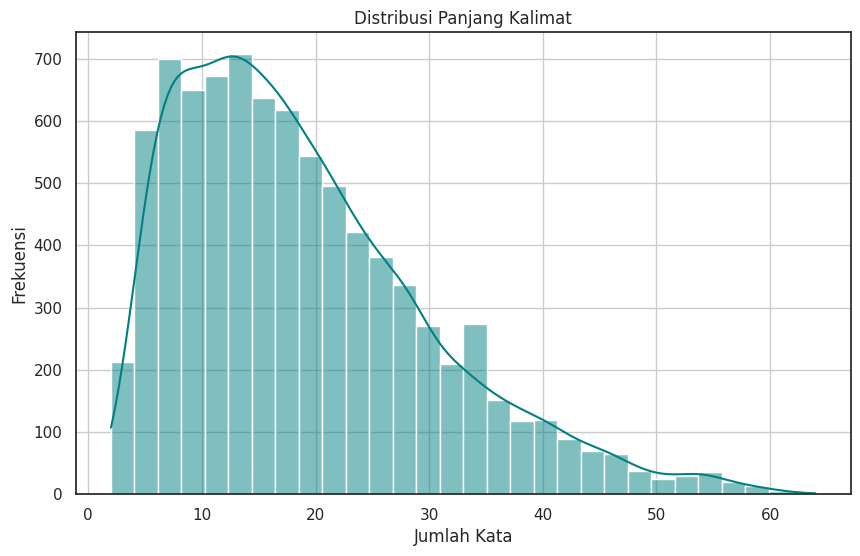

In [33]:
df_train['text_len'] = df_train['Sentence'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
sns.histplot(df_train['text_len'], bins=30, kde=True, color='teal')
plt.title("Distribusi Panjang Kalimat")
plt.xlabel("Jumlah Kata")
plt.ylabel("Frekuensi")
plt.grid(True)
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


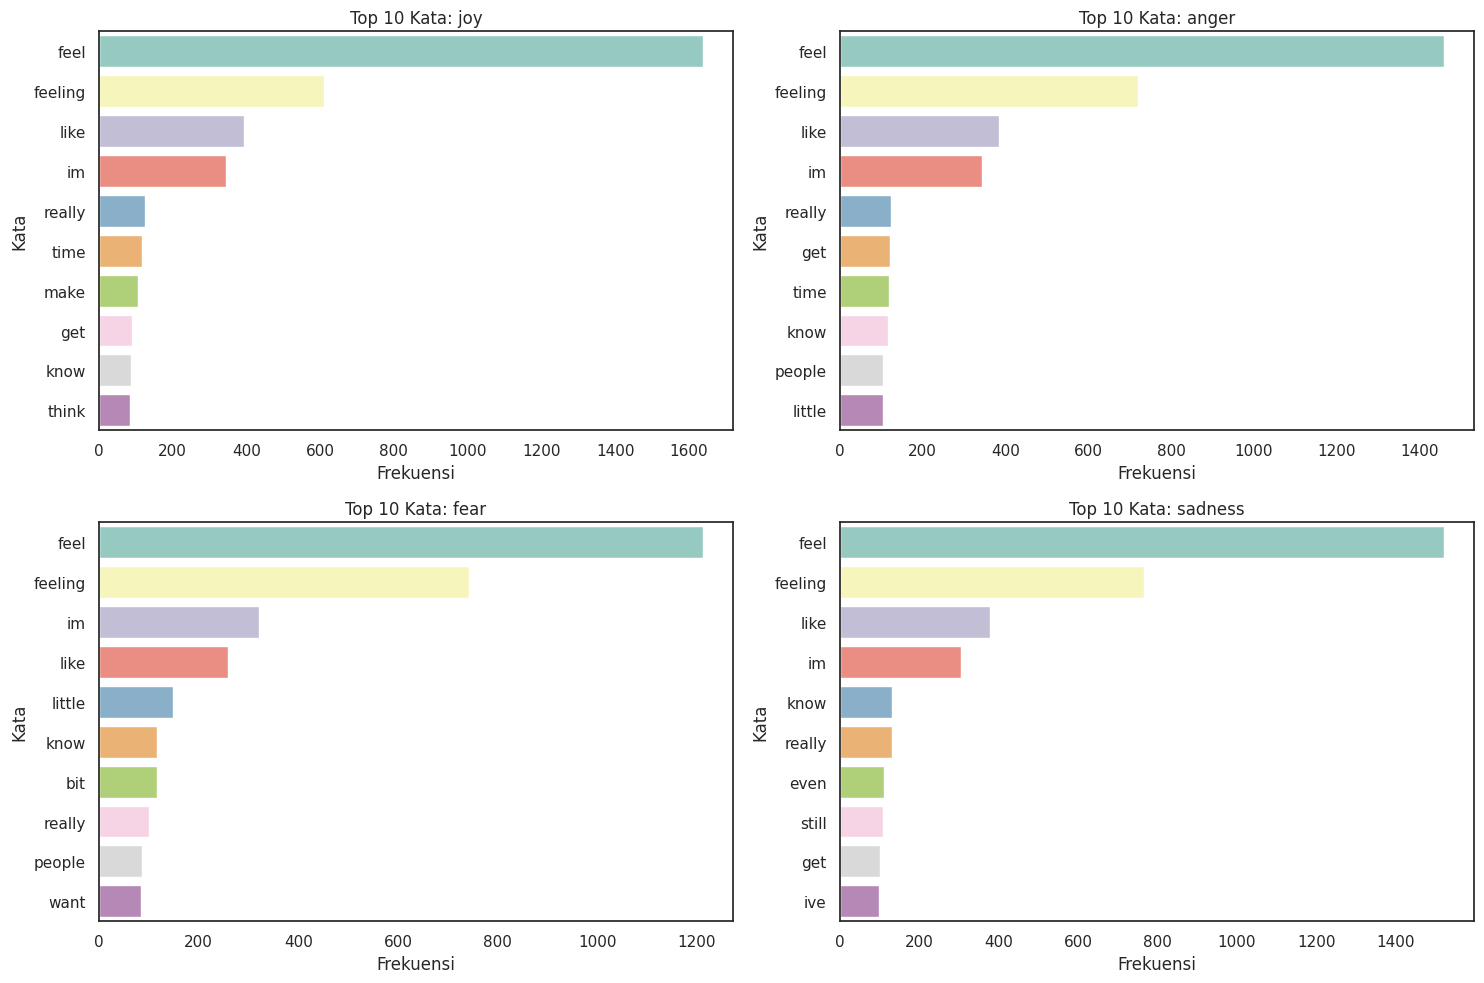

In [34]:
plt.figure(figsize=(15, 10))
for i, label in enumerate(labels):
    plt.subplot(2, (len(labels)+1)//2, i+1)
    words = get_words_by_label(label)
    common_words = Counter(words).most_common(10)
    words_, freqs_ = zip(*common_words)
    sns.barplot(x=list(freqs_), y=list(words_), palette='Set3')
    plt.title(f"Top 10 Kata: {label}")
    plt.xlabel("Frekuensi")
    plt.ylabel("Kata")
plt.tight_layout()
plt.show()

## Data Preparation & Build Model

In [35]:
le = LabelEncoder()
df_train['Label'] = le.fit_transform(df_train['Label'])
df_val['Label'] = le.transform(df_val['Label'])
df_test['Label'] = le.transform(df_test['Label'])

In [36]:
train_ds = Dataset.from_pandas(df_train)
val_ds = Dataset.from_pandas(df_val)
test_ds = Dataset.from_pandas(df_test)

In [37]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

def tokenize(example):
    return tokenizer(example['Sentence'], truncation=True)

train_ds = train_ds.map(tokenize, batched=True)
val_ds = val_ds.map(tokenize, batched=True)
test_ds = test_ds.map(tokenize, batched=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/8496 [00:00<?, ? examples/s]

Map:   0%|          | 0/965 [00:00<?, ? examples/s]

Map:   0%|          | 0/939 [00:00<?, ? examples/s]

In [38]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

In [39]:
tf_train = train_ds.to_tf_dataset(
    columns=['input_ids', 'attention_mask'],
    label_cols='Label',
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator
)

tf_val = val_ds.to_tf_dataset(
    columns=['input_ids', 'attention_mask'],
    label_cols='Label',
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator
)

tf_test = test_ds.to_tf_dataset(
    columns=['input_ids', 'attention_mask'],
    label_cols='Label',
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator
)

I0000 00:00:1748044219.276479      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748044219.277226      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [40]:
num_labels = len(le.classes_)
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [41]:
from transformers import create_optimizer

num_train_steps = len(tf_train) * 3  # 3 epochs
num_warmup_steps = int(0.1 * num_train_steps)  # 10% warm-up

optimizer, schedule = create_optimizer(
    init_lr=2e-5,
    num_train_steps=num_train_steps,
    num_warmup_steps=num_warmup_steps,
    weight_decay_rate=0.01
)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [42]:
model.fit(tf_train, validation_data=tf_val, epochs=3)

model.evaluate(tf_test)

y_true = []
y_pred = []

for batch in tf_test:
    inputs, labels = batch
    logits = model(inputs, training=False).logits
    pred = tf.argmax(logits, axis=1).numpy()
    y_pred.extend(pred)
    y_true.extend(labels.numpy())

print(classification_report(y_true, y_pred, target_names=le.classes_))

Epoch 1/3
531/531 [==============================] - 135s 201ms/step - loss: 0.6621 - accuracy: 0.7192 - val_loss: 0.1786 - val_accuracy: 0.9430
Epoch 2/3
531/531 [==============================] - 106s 199ms/step - loss: 0.1157 - accuracy: 0.9601 - val_loss: 0.1218 - val_accuracy: 0.9617
Epoch 3/3
59/59 [==============================] - 4s 59ms/step - loss: 0.1133 - accuracy: 0.9638
              precision    recall  f1-score   support

       anger       0.93      0.96      0.95       215
        fear       0.97      0.96      0.96       224
         joy       0.98      0.98      0.98       250
     sadness       0.98      0.95      0.97       250

    accuracy                           0.96       939
   macro avg       0.96      0.96      0.96       939
weighted avg       0.96      0.96      0.96       939



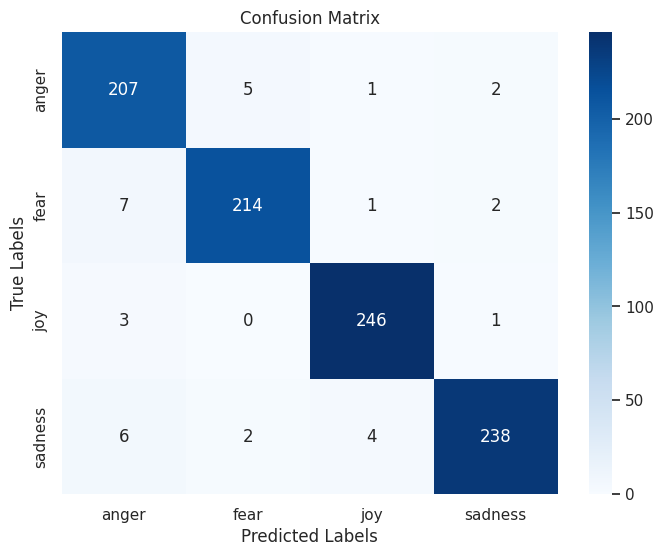

In [43]:
cm = confusion_matrix(y_true, y_pred)
labels = le.classes_  # ['anger', 'fear', 'joy', 'sadness']

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [44]:
# Cetak kesalahan prediksi yang paling sering terjadi
print("Analisis Kesalahan Prediksi:")
for i in range(len(labels)):
    for j in range(len(labels)):
        if i != j and cm[i][j] > 0:
            print(f"Label '{labels[i]}' sering dikira sebagai '{labels[j]}' sebanyak {cm[i][j]} kali.")


Analisis Kesalahan Prediksi:
Label 'anger' sering dikira sebagai 'fear' sebanyak 5 kali.
Label 'anger' sering dikira sebagai 'joy' sebanyak 1 kali.
Label 'anger' sering dikira sebagai 'sadness' sebanyak 2 kali.
Label 'fear' sering dikira sebagai 'anger' sebanyak 7 kali.
Label 'fear' sering dikira sebagai 'joy' sebanyak 1 kali.
Label 'fear' sering dikira sebagai 'sadness' sebanyak 2 kali.
Label 'joy' sering dikira sebagai 'anger' sebanyak 3 kali.
Label 'joy' sering dikira sebagai 'sadness' sebanyak 1 kali.
Label 'sadness' sering dikira sebagai 'anger' sebanyak 6 kali.
Label 'sadness' sering dikira sebagai 'fear' sebanyak 2 kali.
Label 'sadness' sering dikira sebagai 'joy' sebanyak 4 kali.


In [45]:
model.save_pretrained("saved_model/bert_emotion_model")
tokenizer.save_pretrained("saved_model/bert_emotion_model")

('saved_model/bert_emotion_model/tokenizer_config.json',
 'saved_model/bert_emotion_model/special_tokens_map.json',
 'saved_model/bert_emotion_model/vocab.txt',
 'saved_model/bert_emotion_model/added_tokens.json',
 'saved_model/bert_emotion_model/tokenizer.json')

In [46]:
from transformers import TFBertForSequenceClassification, BertTokenizerFast

model = TFBertForSequenceClassification.from_pretrained("saved_model/bert_emotion_model")
tokenizer = BertTokenizerFast.from_pretrained("saved_model/bert_emotion_model")

Some layers from the model checkpoint at saved_model/bert_emotion_model were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at saved_model/bert_emotion_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


Masukkan sebuah kalimat:  I am happy right now


Teks: "I am happy right now"
Skor Probabilitas:
  anger: 0.0015
  fear: 0.0009
  joy: 0.9951
  sadness: 0.0024
Prediksi Emosi: joy



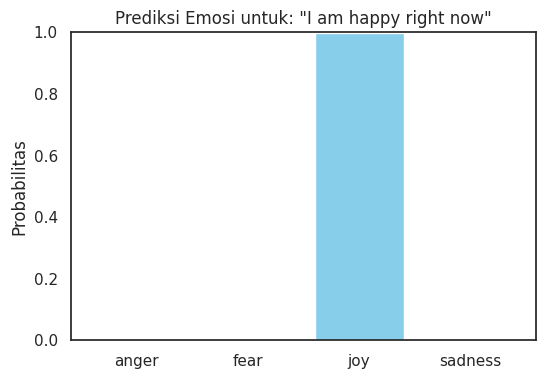

In [47]:
txt = input("Masukkan sebuah kalimat: ")

label_map = {0: "anger", 1: "fear", 2: "joy", 3: "sadness"}

texts = [txt]

inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="tf")

outputs = model(inputs)
logits = outputs.logits
probs = tf.nn.softmax(logits, axis=1).numpy()
predictions = tf.argmax(probs, axis=1).numpy()
for i, text in enumerate(texts):
    print(f"Teks: \"{text}\"")
    print("Skor Probabilitas:")
    for idx, score in enumerate(probs[i]):
        print(f"  {label_map[idx]}: {score:.4f}")
    print(f"Prediksi Emosi: {label_map[predictions[i]]}\n")
    plt.figure(figsize=(6, 4))
    plt.bar(label_map.values(), probs[i], color="skyblue")
    plt.title(f"Prediksi Emosi untuk: \"{text}\"")
    plt.ylabel("Probabilitas")
    plt.ylim(0, 1)
    plt.show()